In [8]:
import os
import glob
import json

# Train model

In [1]:
from keras_segmentation.models.unet import vgg_unet

model = vgg_unet(n_classes=2 ,  input_height=512, input_width=512)

In [3]:
model.train(
    train_images =  "cropped_SVF/train/",
    train_annotations = "cropped_SVF_labels/train/",
    checkpoints_path = "unet_checkpoints" ,
    epochs=7
)

Verifying training dataset


100%|██████████| 944/944 [00:13<00:00, 67.48it/s]
C:\Users\PAKHUIYING\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Dataset verified! 
Epoch 1/7
512/512 [==============================] - 5804s 11s/step - loss: 0.9017 - accuracy: 0.5375
saved  unet_checkpoints.0
Epoch 2/7
512/512 [==============================] - 5161s 10s/step - loss: 0.6927 - accuracy: 0.6213
saved  unet_checkpoints.1
Epoch 3/7
512/512 [==============================] - 5738s 11s/step - loss: 0.6125 - accuracy: 0.6791
saved  unet_checkpoints.2
Epoch 4/7
512/512 [==============================] - 6008s 12s/step - loss: 0.5789 - accuracy: 0.7111
saved  unet_checkpoints.3
Epoch 5/7
512/512 [==============================] - 7054s 14s/step - loss: 0.5643 - accuracy: 0.7360
saved  unet_checkpoints.4
Epoch 6/7
512/512 [==============================] - 5410s 11s/step - loss: 0.5454 - accuracy: 0.7837
saved  unet_checkpoints.5
Epoch 7/7
512/512 [==============================] - 7103s 14s/step - loss: 0.5453 - accuracy: 0.7942
saved  unet_checkpoints.6


# Evaluate model

In [ ]:
print(model.evaluate_segmentation( inp_images_dir="rgb_test/images/"  , annotations_dir="rgb_test/labels/" ) )

# Predict segmentation on an example image

In [ ]:
out = model.predict_segmentation(
    inp="rgb_test/images/output108.png",
    # out_fname="/tmp/out.png"
    out_fname="rgb_test/images/output108_predict.png"
)

# Display the predicted segmented image

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(15,5))
import numpy as np
print(np.max(out))
ax[0].imshow(out,cmap='gray')
ax[1].imshow(plt.imread("rgb_test/images/output108.png"))

# Import the trained model

In [9]:
def find_latest_checkpoint(checkpoints_path, fail_safe=True):

    # This is legacy code, there should always be a "checkpoint" file in your directory

    def get_epoch_number_from_path(path):
        return path.replace(checkpoints_path, "").strip(".")

    # Get all matching files
    all_checkpoint_files = glob.glob(checkpoints_path + ".*")
    
    if len(all_checkpoint_files) == 0:
        all_checkpoint_files = glob.glob(checkpoints_path + "*.*")
    all_checkpoint_files = [ff.replace(".index", "") for ff in
                            all_checkpoint_files]  # to make it work for newer versions of keras
    # print(all_checkpoint_files)
    # Filter out entries where the epoc_number part is pure number
    all_checkpoint_files = list(filter(lambda f: get_epoch_number_from_path(f)
                                       .isdigit(), all_checkpoint_files))
    if not len(all_checkpoint_files):
        # The glob list is empty, don't have a checkpoints_path
        if not fail_safe:
            raise ValueError("Checkpoint path {0} invalid"
                             .format(checkpoints_path))
        else:
            return None

    # Find the checkpoint file with the maximum epoch
    latest_epoch_checkpoint = max(all_checkpoint_files,
                                  key=lambda f:
                                  int(get_epoch_number_from_path(f)))

    return latest_epoch_checkpoint

def model_from_checkpoint_path(checkpoints_path):

    from keras_segmentation.models.all_models import model_from_name
    assert (os.path.isfile(checkpoints_path+"_config.json")
            ), "Checkpoint not found."
    model_config = json.loads(
        open(checkpoints_path+"_config.json", "r").read())
    latest_weights = find_latest_checkpoint(checkpoints_path)
    assert (latest_weights is not None), "Checkpoint not found."
    model = model_from_name[model_config['model_class']](
        model_config['n_classes'], input_height=model_config['input_height'],
        input_width=model_config['input_width'])
    print("loaded weights ", latest_weights)
    model.load_weights(latest_weights)
    return model

model_large = model_from_checkpoint_path("unet_checkpoints")

loaded weights  unet_checkpoints.6


# Evaluate the segmentation

### Evaluate on train images

In [10]:
print(model_large.evaluate_segmentation( inp_images_dir="cropped_SVF/train/"  , annotations_dir="cropped_SVF_labels/train/" ) )

944it [15:48,  1.01s/it]

{'frequency_weighted_IU': 0.8833092233002979, 'mean_IU': 0.80912865907737, 'class_wise_IU': array([0.91879373, 0.69946359])}


### Evaluate on test images

In [12]:
print(model_large.evaluate_segmentation( inp_images_dir="cropped_SVF/test/"  , annotations_dir="cropped_SVF_labels/test/" ) )

236it [04:56,  1.25s/it]

{'frequency_weighted_IU': 0.8807601809271871, 'mean_IU': 0.805529697225073, 'class_wise_IU': array([0.9165861 , 0.69447329])}


# Predict segmentation on a batch of images

In [11]:
predict_directory = "cropped_SVF/predict"
if not os.path.exists(predict_directory):
    os.mkdir(predict_directory)
test_images_directory = "cropped_SVF/test"
for f in os.listdir(test_images_directory):
    output_fn = os.path.splitext(f)[0] + '_predict.png'
    model_large.predict_segmentation(
        inp=os.path.join(test_images_directory,f),
        out_fname=os.path.join(predict_directory,output_fn))

# Display predicted images

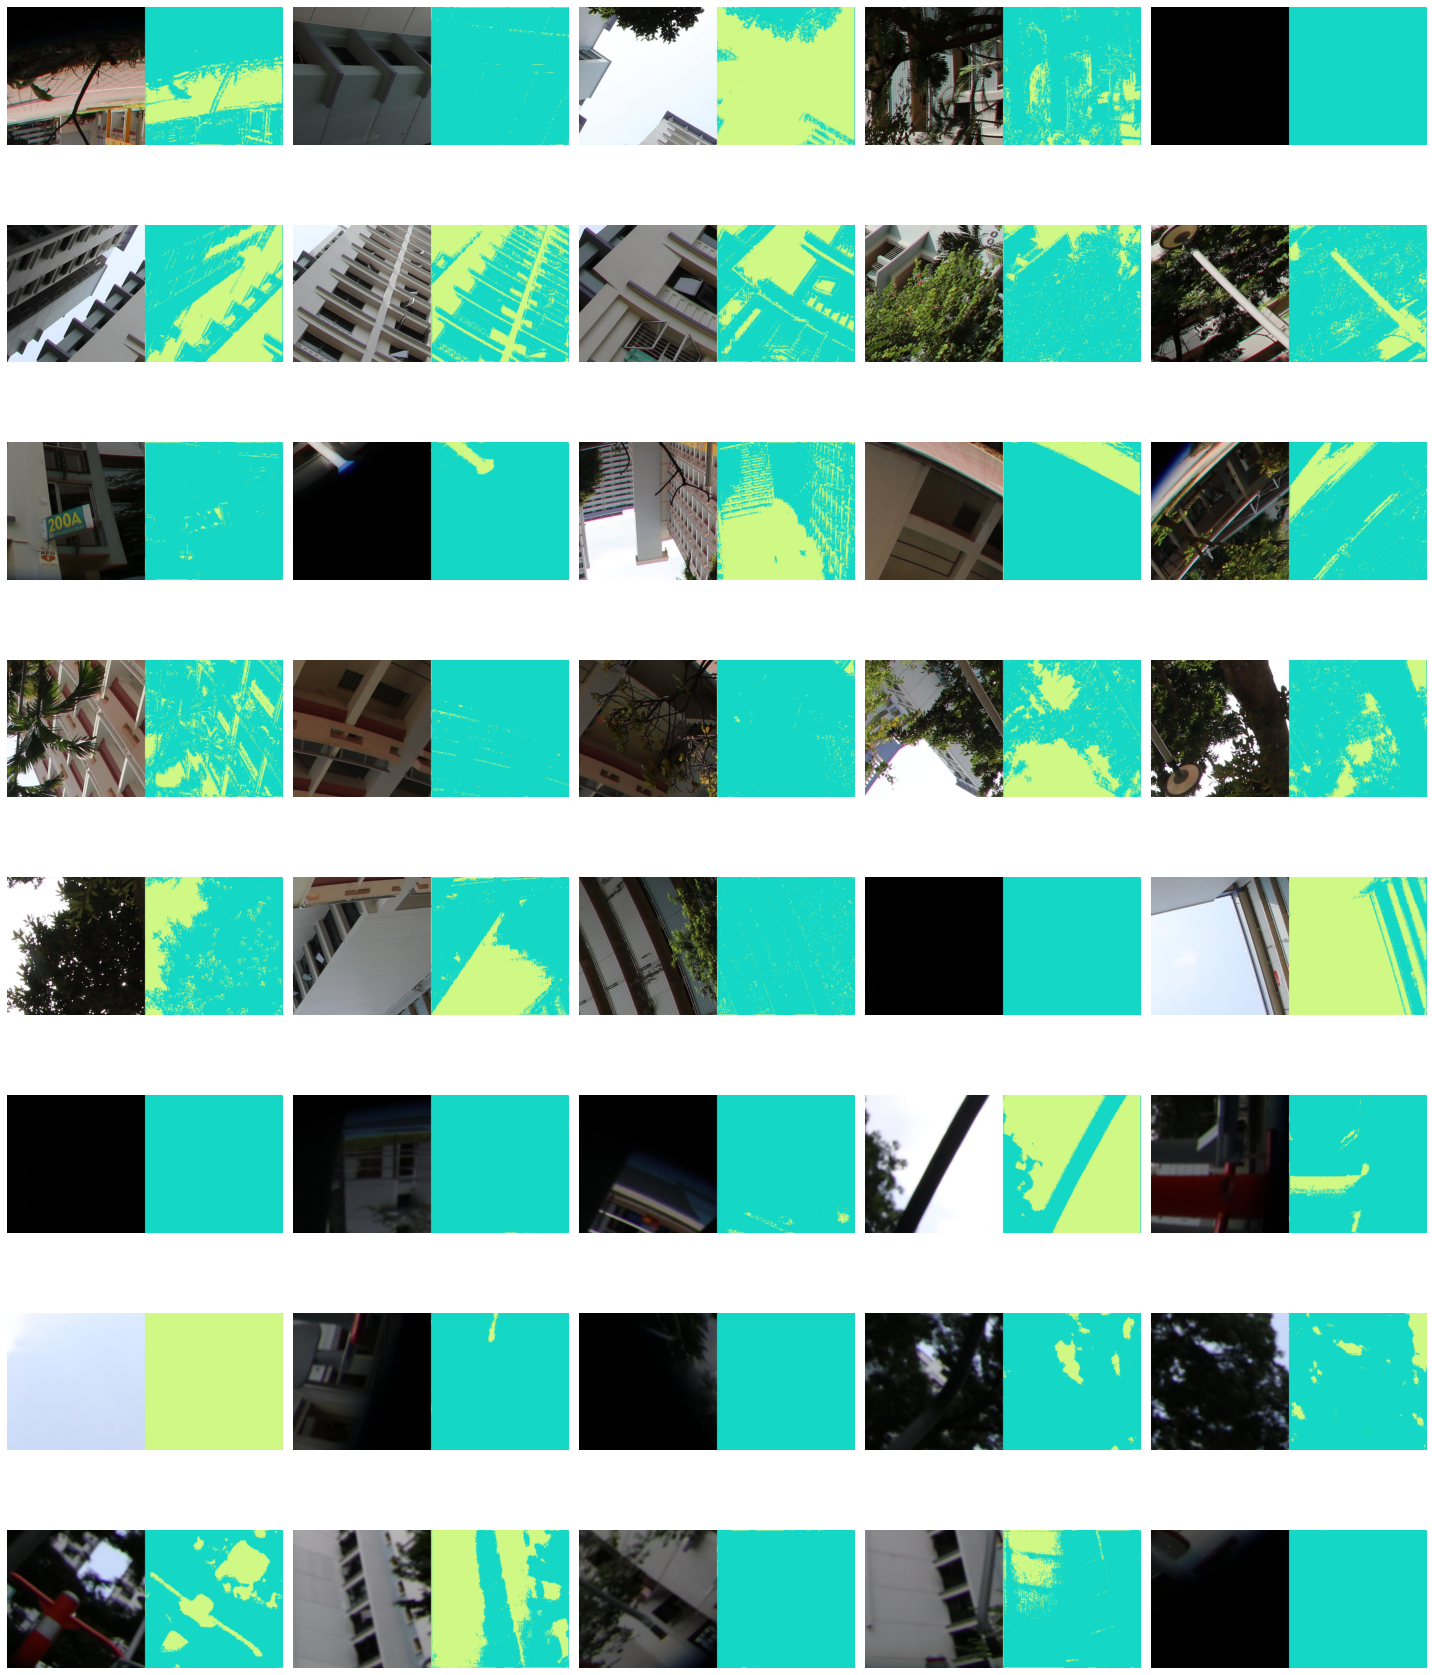

In [15]:
import matplotlib.pyplot as plt
import numpy as np
ground_truth_directory = "cropped_SVF_labels/test"
predict_directory = "cropped_SVF/predict"
test_images_directory = "cropped_SVF/test"

nrow = 8
ncol = 5

fig, axes = plt.subplots(nrow,ncol,figsize=(20,25))
n = int(nrow*ncol)
# ax = axes.flatten()
for ax,fp in zip(axes.flatten(),sorted(os.listdir(test_images_directory))[:n]):
    img = plt.imread(os.path.join(test_images_directory,fp))
    # labelled_img = plt.imread(os.path.join(ground_truth_directory,fp))
    fp = os.path.splitext(fp)[0] + '_predict.png'
    predicted_img = plt.imread(os.path.join(predict_directory,fp))
    im = np.hstack([img,predicted_img])
    ax.imshow(im)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
from sklearn.cluster import KMeans
def cut_into_512(img):
    """
    img has to be opened by cv2.imread(fp,1) #BGR
    """
    def pad_images(img):
        nrow,ncol = img.shape[0],img.shape[1]
        if ncol > 512:
            raise ValueError("Img col is > 512!")
        if len(img.shape) == 3:
            pad_img = np.zeros((512,512,3))
            pad_img[:,:ncol,:] = img
            pad_img = pad_img.astype(np.uint8)
        else:
            pad_img = np.zeros((512,512))
            pad_img[:,:ncol] = img
            pad_img = pad_img.astype(np.uint8)
            
        return pad_img

    nrow,ncol = img.shape[0],img.shape[1]
    if ncol > 512:
        cut_images = {}
        for index,i in enumerate(range(0,nrow,512)): #nrow
            for jindex,j in enumerate(range(0,ncol, 512)): #ncols
                if len(img.shape) == 3:
                    if j+512 <= ncol:
                        cut_images[(index,jindex)] = {'image':img[i:i+512,j:j+512,:],'padded':False}
                        # cut_images.append(img[i:i+512,j:j+512,:])
                    else:
                        padded_img = pad_images(img[i:i+512,j:ncol,:])
                        cut_images[(index,jindex)] = {'image':padded_img,'padded':True,'ncol':ncol}
                        # cut_images.append(padded_img)
                else:
                    if j+512 <= ncol:
                        cut_images[(index,jindex)] = {'image':img[i:i+512,j:j+512],'padded':False}
                        # cut_images.append(img[i:i+512,j:j+512])
                    else:
                        padded_img = pad_images(img[i:i+512,j:ncol])
                        cut_images[(index,jindex)] = {'image':padded_img,'padded':True,'ncol':ncol}
                        # cut_images.append(padded_img)
    else:
        cut_images = None
        print("ncol is already 512!")
    return cut_images #returns cut_dict

def get_mask(cut_images,model):
    for (k,v) in cut_images.items():
        out = model.predict_segmentation(prediction_height=512,prediction_width=512,
        inp=v['image'],#join(test_images_directory,f),
        out_fname=None)#join(predict_directory,output_f))
        out = np.array(out, dtype='uint8')
        out_resize = cv2.resize(out, (512,512), interpolation= cv2.INTER_LINEAR) #resized mask
        cut_images[k]['mask'] = out_resize
    return cut_images

def reconstruct_mask(cut_images):
    """
    cut_images (dict): with keys image, padded, ncol (if padded is True)
    reconstruct mask image from cut_images and save the mask
    """
    cut_img_list = [v['mask'] for k,v in cut_images.items()]
    ncol = len(cut_images.keys())//2
    row1 = np.hstack(cut_img_list[:ncol])
    row2 = np.hstack(cut_img_list[ncol:])
    recon_img = np.vstack([row1,row2])
    if cut_images[1,ncol-1]['padded'] is True:
        end_col = cut_images[1,ncol-1]['ncol']
        recon_img = recon_img[:,:end_col]
    return recon_img

In [ ]:
from matplotlib import cm
def mask_to_rgb(mask,img):
    img_masked = img.copy()
    img_masked[mask == 2] = (128,128,128) #mask caisson
    img_masked[mask==1] = (0,0,0) #mask vessels
    return img_masked

fp = "C:/Users/PAKHUIYING/Documents/Deep_Learning/image_segmentation\\SMI_checkpoints_1"
from keras_segmentation.predict import model_from_checkpoint_path
model_large = model_from_checkpoint_path(fp)

In [ ]:

test_tif = cv2.imread(r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_08_25\2021_08_25_10-32-33_rgb_image_line_03_6542_7991.tif")

In [ ]:
import pandas as pd
import re
def evaluate_segmentation(predicted_mask,label_mask,n_classes=3,save_csv=False,dir=None,filename=None):
    tp = np.zeros(n_classes) #true positives
    tn = np.zeros(n_classes) #true negatives
    fp = np.zeros(n_classes) #false positive
    fn = np.zeros(n_classes) #false negative
    n = np.zeros(n_classes) #negatives based on actual class
    n_pixels = np.zeros(n_classes) #number of pixels in each class based on label, true positive

    pr = predicted_mask.flatten()
    gt = label_mask.flatten()
    for cl_i in range(n_classes):
        tp[cl_i] += np.sum((pr == cl_i) * (gt == cl_i)) #true positives
        tn[cl_i] += np.sum((pr != cl_i) * (gt != cl_i)) #true negatives
        fp[cl_i] += np.sum((pr == cl_i) * ((gt != cl_i))) #false positive type 1 error
        fn[cl_i] += np.sum((pr != cl_i) * ((gt == cl_i))) #false negative type 2 error
        n[cl_i] += np.sum(gt != cl_i) #true negatives
        n_pixels[cl_i] += np.sum(gt == cl_i) #number of pixels in each class based on label
    
    cl_wise_score = tp / (tp + fp + fn + 0.000000000001)
    acc = (tp+tn)/(n_pixels+n)
    n_pixels_norm = n_pixels / np.sum(n_pixels)
    frequency_weighted_IU = np.sum(cl_wise_score*n_pixels_norm) #weighted by the proportion of each class
    mean_IU = np.mean(cl_wise_score)

    evaluation_metrics = {
        "frequency_weighted_IU": frequency_weighted_IU,
        "mean_IU": mean_IU,
        "class_wise_IU": cl_wise_score,
        "accuracy":acc,
        "error_rate": 1-acc
    }

    if save_csv is True:
        df = pd.DataFrame.from_dict(evaluation_metrics)
        df.index = df.index.set_names(['Class'])
        df = df.reset_index()
        df.to_csv(join(dir,'{}.csv'.format(filename)),index=False)
    return evaluation_metrics

In [ ]:
def unet_segmentation(image_fp,model,label_fp=None,preview=True,save_fig=False,dir=None):
    """
    image_fp (str): filepath to image
    model (from checkpoints)
    preview (bool): whether to preview images
    """
    test_tif = cv2.imread(image_fp)
    rgb_tif = cv2.cvtColor(test_tif, cv2.COLOR_BGR2RGB)
    test_tif_list = cut_into_512(test_tif)
    test_tif_list = get_mask(test_tif_list,model)
    recon_mask = reconstruct_mask(test_tif_list)
    masked_img = mask_to_rgb(recon_mask,rgb_tif)
    #evaluate prediction
    
    if preview is True:
        if label_fp is not None:
            label = np.asarray(PIL.Image.open(label_fp))
            fig, ax = plt.subplots(4,1,figsize=(15,10))
            ax[3].imshow(label,cmap='gray',vmin=0,vmax=2)
            ax[3].set_title("Label Mask")
            ax[3].axes.xaxis.set_visible(False)
            ax[3].axes.yaxis.set_visible(False)
        else:
            fig, ax = plt.subplots(3,1,figsize=(15,7))
        ax[0].imshow(rgb_tif)
        ax[0].set_title("Original Image")
        ax[0].axes.xaxis.set_visible(False)
        ax[0].axes.yaxis.set_visible(False)
        ax[1].imshow(masked_img)
        ax[1].set_title("Masked Image")
        ax[1].axes.xaxis.set_visible(False)
        ax[1].axes.yaxis.set_visible(False)
        ax[2].imshow(recon_mask,cmap='gray',vmin=0,vmax=2)
        ax[2].set_title("Predicted Mask")
        ax[2].axes.xaxis.set_visible(False)
        ax[2].axes.yaxis.set_visible(False)
        
        plt.tight_layout()
    
    if save_fig is True and dir is not None:
        file_name = re.search('\\\(.+?).jpg',image_fp).group(1) + '.png'
        plt.savefig(join(dir,file_name))

    if label_fp is None:
        return {'rgb':rgb_tif,'mask':recon_mask,'masked_img':masked_img}#rgb_tif,recon_mask,masked_img
    else:
        return {'rgb':rgb_tif,'mask':recon_mask,'masked_img':masked_img,'label':label}#rgb_tif,recon_mask,masked_img